# Room Occupancy Count Classifier Prediction
Author: Andy Malinsky

### INSTALL ANY DEPENDENCIES requirements file !

In [178]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Bidirectional, GRU, Dense, Input, Dropout
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# Setting seed for reproducibility
np.random.seed(24)

## Load and Prepare Data

In [4]:
# Load dataset
ro_data = pd.read_pickle("ro_data.pkl")
ro_data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime,time_diff,is_large_gap,group
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,...,0.06,390,0.769231,0,0,1,2017-12-22 10:49:41,NaT,False,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,0.06,390,0.646154,0,0,1,2017-12-22 10:50:12,0 days 00:00:31,False,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,0.06,390,0.519231,0,0,1,2017-12-22 10:50:42,0 days 00:00:30,False,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,0.09,390,0.388462,0,0,1,2017-12-22 10:51:13,0 days 00:00:31,False,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,0.06,390,0.253846,0,0,1,2017-12-22 10:51:44,0 days 00:00:31,False,1


In [5]:
# Using the second half of group 1 as testing data because it has a good distribution of occupancy counts
group_1_data = ro_data[ro_data['group'] == 1]
split_index = len(group_1_data) // 2  # Midpoint of group 1

# Define training and testing sets
test_data = group_1_data.iloc[split_index:]  # Second half of group 1 as test set
train_data = ro_data[~ro_data.index.isin(test_data.index)]  # All other data as training set

# Features selected based on correlation analysis in eda-data-clean.ipynb notebook
filtered_columns = [
    'S1_Temp', 'S1_Light', 
    'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
    'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
]
target_column = ['Room_Occupancy_Count']
num_classes = len(ro_data['Room_Occupancy_Count'].unique())

X_train, y_train = train_data[filtered_columns], train_data[target_column]
X_test, y_test = test_data[filtered_columns], test_data[target_column]

# Reshape target variable to match output requirements
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Display the new training and test set sizes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7476, 10), (2653, 10), (7476, 1), (2653, 1))

In [6]:
# Create sequences for GRU model
def create_sequences(x_data, y_data, seq_length):
    seq_arrays = []
    seq_labs = []
    
    for start in range(0, len(x_data) - seq_length - 1):
        seq_arrays.append(x_data[start:start + seq_length])
        seq_labs.append(y_data[start + seq_length - 1])

    # Convert to numpy arrays and floats for keras layers      
    seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype = object).astype(np.float32) 
    
    return seq_arrays, seq_labs

In [110]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create sequences for model input
seq_length = 10 # define sequence length
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

# Reshape Targets
y_train_seq = y_train_seq.reshape(-1, 1)
y_test_seq = y_test_seq.reshape(-1, 1)

X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape

((7465, 10, 10), (7465, 1), (2642, 10, 10), (2642, 1))

In [251]:
# View Room Occupancy Count Distributions
counts_train = pd.DataFrame(y_train)
counts_test = pd.DataFrame(y_test)
train_counts = counts_train.value_counts().rename('train_occupancy_count')
test_counts = counts_test.value_counts().rename('test_occupancy_count')
value_counts_df = pd.concat([train_counts, test_counts], axis=1, sort=False).fillna(0)
value_counts_df.transpose()

,0,3,2,1
train_occupancy_count,6357,564,350,205
test_occupancy_count,1871,130,398,254


## Model Training

In [64]:
# View Input Shape
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
input_shape

(10, 10)

In [158]:
def create_model(input_shape, num_classes):
    # Create a Bidirectional GRU model
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)),
        Bidirectional(GRU(32, recurrent_dropout=0.2)),
        Dropout(0.3),
        Dense(units=num_classes, activation='softmax')
    ])

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# View model summary
create_model(input_shape=input_shape, num_classes=num_classes).summary()

# To prevent overfitting on imbalanced classes, calculate balanced class weights
y_train_labels = y_train_seq.astype(int).reshape(-1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_labels)
class_weights_train = dict(zip(np.unique(y_train_seq), class_weights))

model = KerasClassifier(model=create_model, input_shape=input_shape, num_classes=num_classes, 
                        epochs=10, batch_size=32, verbose=1, class_weight=class_weights_train)

Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_299               │ (None, 10, 128)        │        29,184 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_300               │ (None, 64)             │        31,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,548 (236.52 KB)

 Trainable params: 60,548 (236.52 KB)

 Non-trainable params: 0 (0.00 B)

In [170]:
# Run Grid Search with TimeSeries Cross Validation
tscv = TimeSeriesSplit(n_splits=5) 
param_grid = {'epochs': [10], 'batch_size': [32]}
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='f1_macro', verbose=1)
grid_search.fit(X_train_seq, y_train_seq)
best_model = grid_search.best_estimator_

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)
print('Average cross-validation F1-score (macro)', grid_search.cv_results_['mean_test_score'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3210 - loss: 4.4773
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7043 - loss: 2.8543
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7926 - loss: 2.3533
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8508 - loss: 1.6903
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8721 - loss: 1.6312
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8928 - loss: 1.3423
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8803 - loss: 1.3675
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9005 - loss: 1.1526
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9040 - loss: 1.1368
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9232 - loss: 0.9792
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step

In [172]:
# Train the model
history = best_model.fit(X_train_seq, y_train_seq)

Epoch 1/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7636 - loss: 0.9963
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8585 - loss: 0.6910
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8820 - loss: 0.6674
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9190 - loss: 0.6120
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9205 - loss: 0.5677
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9365 - loss: 0.5557
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9334 - loss: 0.5990
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9396 - loss: 0.4825
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9398 - loss: 0.4519
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9486 - loss: 0.4138


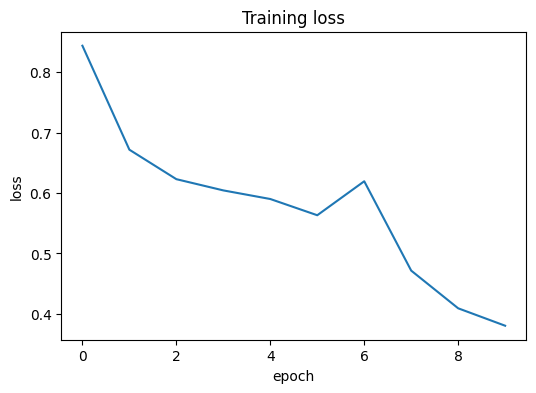

In [193]:
# Summarize history for Loss
fig_acc = plt.figure(figsize=(6,4))
plt.plot(history.history_['loss'])
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

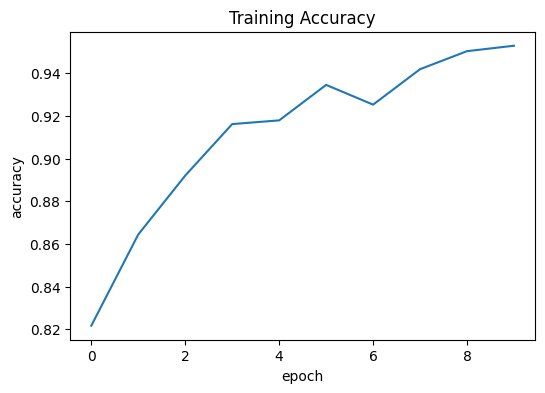

In [192]:
# Summarize history for Accuracy
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(history.history_['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [191]:
# Evaluate the model on the test set
y_pred_test = best_model.predict(X_test_seq)
accuracy = accuracy_score(y_test_seq, y_pred_test)
f1_score = f1_score(y_test_seq, y_pred_test, average='macro')
print(f"Test Accuracy: {accuracy}")
print(f"F1-score (macro): {f1_score}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Accuracy: 0.8750946252838758
F1-score (macro): 0.7134806624353557


In [ ]:
# Classification Report
report = classification_report(y_test_seq, y_pred_test, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0.0,1.000000,0.967742,0.983607,1860.000000
1.0,0.800654,0.964567,0.875000,254.000000
2.0,0.840426,0.396985,0.539249,398.000000
3.0,0.313218,0.838462,0.456067,130.000000
accuracy,0.875095,0.875095,0.875095,0.875095
macro avg,0.738574,0.791939,0.713481,2642.000000
weighted avg,0.923003,0.875095,0.880268,2642.000000


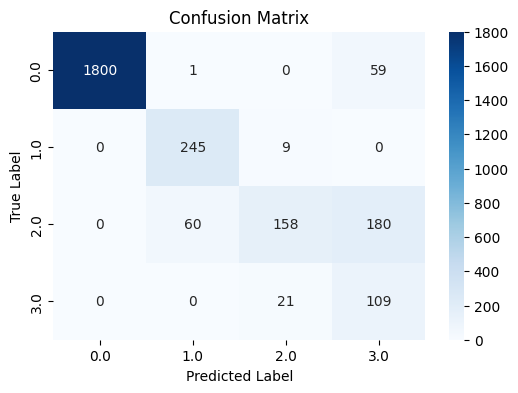

In [187]:
# Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred_test)
df_cm = pd.DataFrame(cm, index=np.unique(y_test_seq), columns=np.unique(y_test_seq))

plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Define path to save model
model_path = 'BiGRU_model1.keras'

In [ ]:
# Predictions
probabilities = model.predict(X_test_seq)
predictions = np.argmax(probabilities, axis=1)

print("Probabilities:\n", probabilities)
print("Predictions:\n", predictions)
print("Actual:\n", y_test_seq)

In [ ]:
# test out different sequence lengths
